In [4]:

import pandas as pd
import re
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings('ignore')


In [2]:
pip install statsmodels


   ---------------------------------------- 0.0/9.6 MB ? eta -:--:--
   ---------- ----------------------------- 2.6/9.6 MB 15.1 MB/s eta 0:00:01
   --------------------- ------------------ 5.2/9.6 MB 13.9 MB/s eta 0:00:01
   -------------------------------- ------- 7.9/9.6 MB 12.8 MB/s eta 0:00:01
   ---------------------------------------- 9.6/9.6 MB 12.4 MB/s  0:00:00

   ---------------------------------------- 0/2 [patsy]
   ---------------------------------------- 0/2 [patsy]
   ---------------------------------------- 0/2 [patsy]
   ---------------------------------------- 0/2 [patsy]
   ---------------------------------------- 0/2 [patsy]
   ---------------------------------------- 0/2 [patsy]
   ---------------------------------------- 0/2 [patsy]
   -------------------- ------------------- 1/2 [statsmodels]
   -------------------- ------------------- 1/2 [statsmodels]
   -------------------- ------------------- 1/2 [statsmodels]
   -------------------- ------------------- 1/2


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
pip install lxml

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


### Data Cleaning

#### Vehicle registration


In [5]:
url_2023 = "https://afdc.energy.gov/vehicle-registration?year=2023"
tables = pd.read_html(url_2023)
df_2023 = tables[0] 

url_2022 = "https://afdc.energy.gov/vehicle-registration?year=2022"
tables_2022 = pd.read_html(url_2022)
df_2022 = tables_2022[0]

url_2021 = "https://afdc.energy.gov/vehicle-registration?year=2021"
tables_2021 = pd.read_html(url_2021)
df_2021 = tables_2021[0]

url_2020 = "https://afdc.energy.gov/vehicle-registration?year=2020"
tables_2020 = pd.read_html(url_2020)
df_2020 = tables_2020[0] 

url_2019 = "https://afdc.energy.gov/vehicle-registration?year=2019"
tables_2019 = pd.read_html(url_2019)
df_2019 = tables[0] 

url_2018 = "https://afdc.energy.gov/vehicle-registration?year=2018"
tables_2018 = pd.read_html(url_2018)
df_2018 = tables[0] 

url_2017 = "https://afdc.energy.gov/vehicle-registration?year=2017"
tables = pd.read_html(url_2017)
df_2017 = tables[0] 

url_2016= "https://afdc.energy.gov/vehicle-registration?year=2016"
tables = pd.read_html(url_2016)
df_2016 = tables[0] 

In [6]:
registration_2023 = df_2023.iloc[:, :2]
registration_2022 = df_2022.iloc[:, :2]
registration_2021 = df_2021.iloc[:, :2]
registration_2020 = df_2020.iloc[:, :2]
registration_2019 = df_2019.iloc[:, :2]
registration_2018 = df_2018.iloc[:, :2]
registration_2017 = df_2017.iloc[:, :2]
registration_2016 = df_2016.iloc[:, :2]


# Combine all years 2016-2023
all_registrations = pd.concat([
    registration_2016, registration_2017, registration_2018, registration_2019,
    registration_2020, registration_2021, registration_2022, registration_2023
], axis=0)

# Standardize column names
all_registrations.columns = ['State', 'Registrations']

# Add Year column
all_registrations['Year'] = (
    [2016]*len(registration_2016) +
    [2017]*len(registration_2017) +
    [2018]*len(registration_2018) +
    [2019]*len(registration_2019) +
    [2020]*len(registration_2020) +
    [2021]*len(registration_2021) +
    [2022]*len(registration_2022) +
    [2023]*len(registration_2023)
)

all_registrations.head()


,State,Registrations,Year
0,Alabama,500,2016
1,Alaska,200,2016
2,Arizona,4700,2016
3,Arkansas,200,2016
4,California,141500,2016


#### Charging ports

In [7]:

# Helper function to extract the second number from Ports column
def extract_second_number(s):
    if pd.isna(s):
        return pd.NA
    s = str(s)
    parts = [p.strip() for p in re.split(r"\||/", s) if p.strip() != '']
    if len(parts) >= 2:
        num = parts[1].replace(',', '')
        try:
            return int(num)
        except Exception:
            return pd.NA
    return pd.NA

# Dictionary to store each year's processed DataFrame
ports_simple = {}

for year in range(2016, 2024):  # 2016–2023
    # Read CSV (no header, treat all as string)
    df = pd.read_csv(f'Datasets/{year}_ports.csv', header=None, dtype=str)

    # Slice rows and columns (adjust indices if needed)
    df = df.iloc[3:107, [0, 4]].rename(columns={0: 'State', 4: 'Ports'})

    # Clean State column
    df['State'] = df['State'].astype(str).str.strip()
    df = df[df['State'].notna() & (df['State'] != '')]

    # Extract Charging_Outlets
    df['Charging_Outlets'] = df['Ports'].apply(extract_second_number)

    # Keep only State + sum of Charging_Outlets
    df_simple = (
        df.dropna(subset=['State'])
          .groupby('State', as_index=False)['Charging_Outlets']
          .sum(min_count=1)
    )

    # Save in dictionary
    ports_simple[year] = df_simple

# Example: view 2016 processed data
ports_simple[2016]


,State,Charging_Outlets
0,Alabama,227
1,Alaska,5
2,Arizona,988
3,Arkansas,89
4,California,13655
5,Colorado,978
6,Connecticut,725
7,Delaware,67
8,District of Columbia,241
9,Florida,2091


In [8]:
# Concatenate all years into a single DataFrame with a Year column
all_ports = pd.concat(
    [df.assign(Year=year) for year, df in ports_simple.items()],
    axis=0,
    ignore_index=True
)

all_ports.head()


,State,Charging_Outlets,Year
0,Alabama,227,2016
1,Alaska,5,2016
2,Arizona,988,2016
3,Arkansas,89,2016
4,California,13655,2016


#### Population

In [9]:

# Load the CSV
pop_before_2020 = pd.read_csv('Datasets/population_before2020.csv', dtype=str)

# Keep only relevant columns: State + POPESTIMATE2016-2019 + Base2020-2023 if present
columns_to_keep = ['NAME'] + [f'POPESTIMATE{y}' for y in range(2016, 2020)]
# If your file also contains 2020–2023, include them
columns_to_keep += [f'POPESTIMATE{y}' for y in range(2020, 2024) if f'POPESTIMATE{y}' in pop_before_2020 .columns]

pop_before_2020 = pop_before_2020[columns_to_keep]

# Rename columns for consistency
pop_before_2020 = pop_before_2020.rename(columns={
    'NAME': 'State',
    **{f'POPESTIMATE{y}': str(y) for y in range(2016, 2024) if f'POPESTIMATE{y}' in pop_before_2020 .columns}
})

# Reset index
pop_before_2020 = pop_before_2020.reset_index(drop=True)

# Display the head
pop_before_2020.head()


,State,2016,2017,2018,2019
0,United States,322941311,324985539,326687501,328239523
1,Northeast Region,56042330,56059240,56046620,55982803
2,Midwest Region,67987540,68126781,68236628,68329004
3,South Region,122351760,123542189,124569433,125580448
4,West Region,76559681,77257329,77834820,78347268


In [10]:
# Load the CSV
pop_after_2020 = pd.read_csv('DSC190/Datasets/population_estimate.csv', dtype=str)

# Keep only relevant columns: State + POPESTIMATE2020-2023 + Base2020 if needed
columns_to_keep = ['NAME', 'ESTIMATESBASE2020'] + [f'POPESTIMATE{y}' for y in range(2020, 2024)]
pop_after_2020 = pop_after_2020[columns_to_keep]

# Rename columns for clarity
pop_after_2020 = pop_after_2020.rename(columns={
    'NAME': 'State',
    'ESTIMATESBASE2020': 'Base2020',
    'POPESTIMATE2020': '2020',
    'POPESTIMATE2021': '2021',
    'POPESTIMATE2022': '2022',
    'POPESTIMATE2023': '2023'
})

# Reset index
pop_after_2020 = pop_after_2020.reset_index(drop=True)

# Show the cleaned DataFrame
pop_after_2020.head()


,State,Base2020,2020,2021,2022,2023
0,United States,331515736,331577720,332099760,334017321,336806231
1,Northeast Region,57617706,57431458,57252533,57159597,57398303
2,New England,15122011,15057350,15118145,15175633,15263573
3,Middle Atlantic,42495695,42374108,42134388,41983964,42134730
4,Midwest Region,68998970,68984258,68872831,68903297,69186401


In [11]:
# Merge on State
population_df = pd.merge(
    pop_before_2020, 
    pop_after_2020, 
    on='State', 
    how='outer'  
)
year_columns = [str(y) for y in range(2016, 2024)]
population_df = population_df[['State'] + year_columns]

population_df.head()

,State,2016,2017,2018,2019,2020,2021,2022,2023
0,Alabama,4863525,4874486,4887681,4903185,5033094,5049196,5076181,5117673
1,Alaska,741456,739700,735139,731545,733017,734420,734442,736510
2,Arizona,6941072,7044008,7158024,7278717,7187135,7274078,7377566,7473027
3,Arkansas,2989918,3001345,3009733,3017804,3014546,3026870,3047704,3069463
4,California,39167117,39358497,39461588,39512223,39521958,39142565,39142414,39198693


### Data Analysis
#### Merge data

In [12]:
# Per-capita analysis: merge data, compute metrics, run correlations and regressions

# --- Prepare population dataframe (wide -> long) ---
# Expect population_df to have columns like 'State', 2016 -2023
pop = population_df.copy()
pop.columns = pop.columns.map(str)

# If column names are numeric strings, ensure they exist; otherwise try alternatives
years = ['2016','2017','2018','2019','2020','2021','2022','2023']
year_cols = [c for c in pop.columns if str(c) in years]
if not year_cols:
    # try exact keys
    for k in years:
        if k in pop.columns:
            year_cols.append(k)

if 'State' not in pop.columns and 'NAME' in pop.columns:
    pop = pop.rename(columns={'NAME':'State'})

# Melt to long format
pop_long = pop.melt(id_vars=['State'], value_vars=[c for c in years if c in pop.columns],
                    var_name='Year', value_name='Population')
pop_long['Year'] = pop_long['Year'].astype(int)
pop_long['Population'] = pd.to_numeric(pop_long['Population'], errors='coerce')

# --- Clean registrations ---
regs = all_registrations.copy()
# Ensure Year column numeric
if regs['Year'].dtype == object:
    regs['Year'] = regs['Year'].astype(str).str.extract(r"(\d{4})").astype(float).astype('Int64')
else:
    regs['Year'] = regs['Year'].astype(int)

# Clean Registrations numeric
regs['Registrations'] = regs['Registrations'].astype(str).str.replace(r'[^0-9]', '', regex=True)
regs['Registrations'] = pd.to_numeric(regs['Registrations'], errors='coerce')

# --- Clean ports ---
ports = all_ports.copy()
if 'Charging_Outlets' in ports.columns:
    ports['Charging_Outlets'] = pd.to_numeric(ports['Charging_Outlets'], errors='coerce')
else:
    # fallback: if Ports exists
    if 'Ports' in ports.columns:
        ports['Charging_Outlets'] = ports['Ports'].astype(str).str.replace(r'[^0-9]', '', regex=True)
        ports['Charging_Outlets'] = pd.to_numeric(ports['Charging_Outlets'], errors='coerce')

# Ensure Year numeric
ports['Year'] = ports['Year'].astype(int)

# Standardize State names by stripping whitespace
for df in (ports, regs, pop_long):
    df['State'] = df['State'].astype(str).str.strip()

# --- Merge ---
merged = (
    ports.merge(regs[['State','Year','Registrations']], on=['State','Year'], how='inner')
        .merge(pop_long[['State','Year','Population']], on=['State','Year'], how='inner')
)

# Drop rows with missing key values
merged = merged.dropna(subset=['Charging_Outlets','Registrations','Population']).copy()

# Derived metrics
merged['Outlets_per_100k'] = merged['Charging_Outlets'] / merged['Population'] * 100000
merged['EVs_per_1000'] = merged['Registrations'] / merged['Population'] * 1000
merged['log_Outlets_pc'] = np.log1p(merged['Charging_Outlets'] / merged['Population'])
merged['log_EVs_pc'] = np.log1p(merged['Registrations'] / merged['Population'])

print(merged[['State','Year','Charging_Outlets','Registrations','Population']].head())

        State  Year  Charging_Outlets  Registrations  Population
0     Alabama  2016               227            500   4863525.0
1      Alaska  2016                 5            200    741456.0
2     Arizona  2016               988           4700   6941072.0
3    Arkansas  2016                89            200   2989918.0
4  California  2016             13655         141500  39167117.0


#### Correlation & OLS

In [13]:
# --- Descriptive & correlations ---
print('\nDescriptive stats:')
print(merged[['Outlets_per_100k','EVs_per_1000']].describe())
pearson = merged['Outlets_per_100k'].corr(merged['EVs_per_1000'], method='pearson')
spearman = merged['Outlets_per_100k'].corr(merged['EVs_per_1000'], method='spearman')
print(f"Pearson correlation (Outlets_per_100k vs EVs_per_1000): {pearson:.3f}")
print(f"Spearman correlation: {spearman:.3f}")

# --- Cross-sectional OLS on latest year ---
latest_year = merged['Year'].max()
df_latest = merged[merged['Year']==latest_year].copy()
print(f"\nRunning cross-sectional OLS for year {latest_year}, N={len(df_latest)}")
model_cs = smf.ols('EVs_per_1000 ~ Outlets_per_100k', data=df_latest).fit(cov_type='HC1')
print(model_cs.summary())

# --- Panel with state and year fixed effects (dummies) and clustered SEs by state ---
print('\nRunning pooled OLS with state and year fixed effects (clustered SEs by state)')
panel_formula = 'EVs_per_1000 ~ Outlets_per_100k + C(State) + C(Year)'
model_panel = smf.ols(panel_formula, data=merged).fit(cov_type='cluster', cov_kwds={'groups': merged['State']})
print(model_panel.summary())


Descriptive stats:
       Outlets_per_100k  EVs_per_1000
count        408.000000    408.000000
mean          27.939113      4.324157
std           25.363281      4.961843
min            0.674349      0.000000
25%           12.056040      0.836619
50%           20.219310      2.655282
75%           34.872810      5.599008
max          168.479494     32.057191
Pearson correlation (Outlets_per_100k vs EVs_per_1000): 0.538
Spearman correlation: 0.633

Running cross-sectional OLS for year 2023, N=51
                            OLS Regression Results                            
Dep. Variable:           EVs_per_1000   R-squared:                       0.451
Model:                            OLS   Adj. R-squared:                  0.440
Method:                 Least Squares   F-statistic:                     10.57
Date:                Thu, 11 Dec 2025   Prob (F-statistic):            0.00209
Time:                        08:53:37   Log-Likelihood:                -145.93
No. Observations:        

#### Visualizations

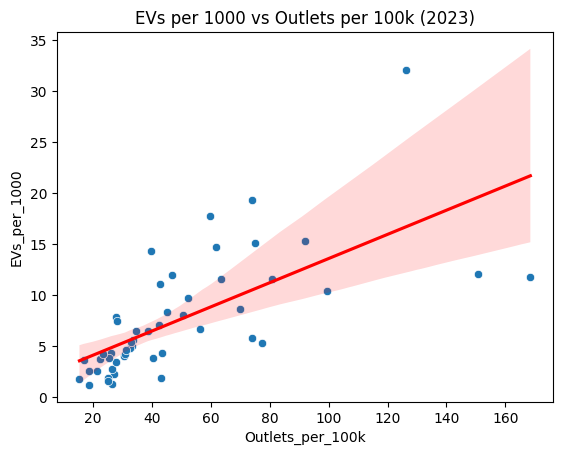

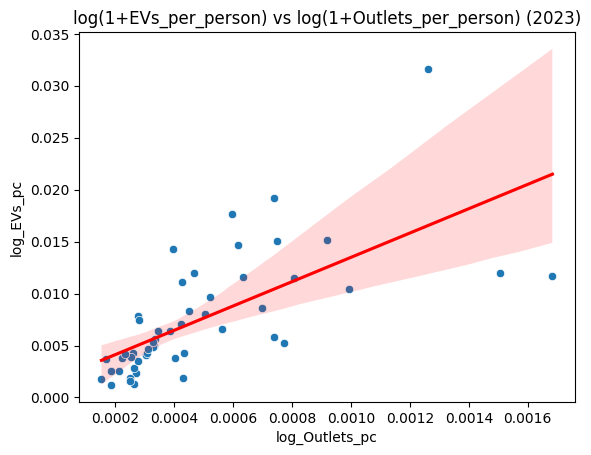

In [14]:
# --- Simple plots ---
plt.figure()
sns.scatterplot(x='Outlets_per_100k', y='EVs_per_1000', data=df_latest)
sns.regplot(x='Outlets_per_100k', y='EVs_per_1000', data=df_latest, scatter=False, ci=95, line_kws={'color':'red'})
plt.title(f'EVs per 1000 vs Outlets per 100k ({latest_year})')
plt.show()

# Log-log scatter
plt.figure()
sns.scatterplot(x='log_Outlets_pc', y='log_EVs_pc', data=df_latest)
sns.regplot(x='log_Outlets_pc', y='log_EVs_pc', data=df_latest, scatter=False, ci=95, line_kws={'color':'red'})
plt.title(f'log(1+EVs_per_person) vs log(1+Outlets_per_person) ({latest_year})')
plt.show()

### State-year comparative analysis

In [15]:
# State-year comparative analysis: rankings, growth, small-multiples, quartiles, and heatmaps

# Expect `merged` to exist from previous cell with columns: State, Year, Charging_Outlets, Registrations, Population, Outlets_per_100k, EVs_per_1000

# 1) Top and bottom states by EVs per 1000 in latest year
latest_year = merged['Year'].max()
df_latest = merged[merged['Year']==latest_year].copy()
ranked = df_latest.sort_values('EVs_per_1000', ascending=False)
print('\nTop 10 states by EVs per 1000 (latest year):')
print(ranked[['State','EVs_per_1000','Outlets_per_100k']].head(10).to_string(index=False))
print('\nBottom 10 states by EVs per 1000 (latest year):')
print(ranked[['State','EVs_per_1000','Outlets_per_100k']].tail(10).to_string(index=False))

# 2) Growth rates 2026 -> latest_year for EVs per 1000 and Outlets per 100k
start_year = 2016
end_year = latest_year
pivot = merged.pivot(index='State', columns='Year', values='EVs_per_1000')
if start_year in pivot.columns and end_year in pivot.columns:
    pivot['EV_growth_pct'] = (pivot[end_year] - pivot[start_year]) / pivot[start_year].replace({0: np.nan}) * 100
else:
    pivot['EV_growth_pct'] = np.nan

pivot_out = merged.pivot(index='State', columns='Year', values='Outlets_per_100k')
if start_year in pivot_out.columns and end_year in pivot_out.columns:
    pivot_out['Outlets_growth_pct'] = (pivot_out[end_year] - pivot_out[start_year]) / pivot_out[start_year].replace({0: np.nan}) * 100
else:
    pivot_out['Outlets_growth_pct'] = np.nan

growth = pd.DataFrame({
    'EV_growth_pct': pivot['EV_growth_pct'],
    'Outlets_growth_pct': pivot_out['Outlets_growth_pct']
}).reset_index()
print('\nTop 10 EV growth 2016->{}:'.format(end_year))
print(growth.sort_values('EV_growth_pct', ascending=False).head(10).to_string(index=False))




Top 10 states by EVs per 1000 (latest year):
               State  EVs_per_1000  Outlets_per_100k
          California     32.057191        126.108797
          Washington     19.357745         74.032876
              Hawaii     17.760671         59.664753
            Colorado     15.267721         92.046907
              Oregon     15.139928         74.994364
              Nevada     14.746312         61.816291
          New Jersey     14.371551         39.692346
             Vermont     12.023900        150.761205
             Arizona     12.016550         46.915393
District of Columbia     11.784835        168.479494

Bottom 10 states by EVs per 1000 (latest year):
        State  EVs_per_1000  Outlets_per_100k
         Iowa      2.796408         26.565880
     Kentucky      2.549117         18.656901
      Alabama      2.540217         21.415983
     Arkansas      2.313108         27.138297
      Wyoming      1.880127         43.071990
 South Dakota      1.851237         25.263937


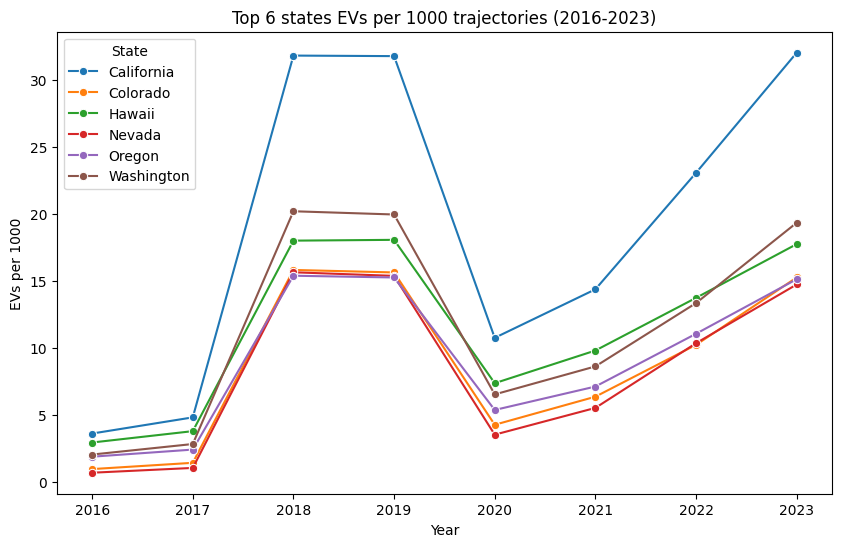

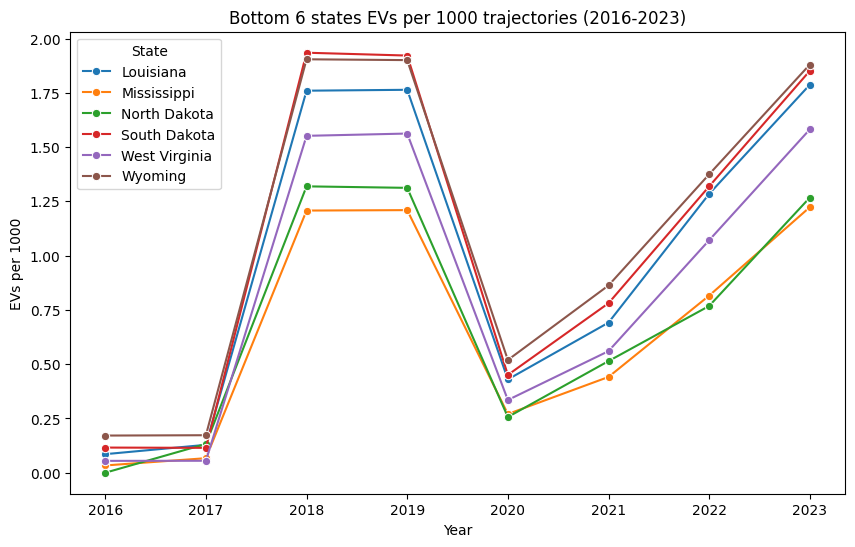

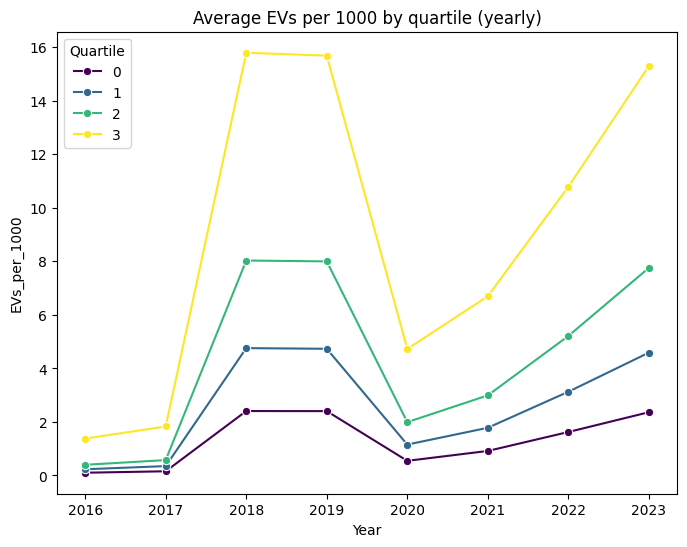


Yearly correlations:
       pearson  spearman
Year                    
2016  0.603526  0.744163
2017  0.658030  0.688416
2018  0.648475  0.704796
2019  0.648636  0.754027
2020  0.665256  0.809231
2021  0.696174  0.802534
2022  0.668609  0.798914
2023  0.671395  0.821448


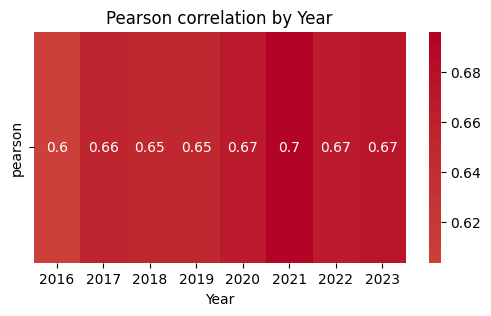

In [16]:
# 3) Small multiples: trajectories for top 6 and bottom 6 states by EVs per 1000
top_states = ranked['State'].head(6).tolist()
bottom_states = ranked['State'].tail(6).tolist()

def plot_trajectories(states, title):
    df = merged[merged['State'].isin(states)].copy()
    plt.figure(figsize=(10,6))
    sns.lineplot(data=df, x='Year', y='EVs_per_1000', hue='State', marker='o')
    ax = plt.gca()
    # force integer ticks for years
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    years = sorted(df['Year'].unique())
    ax.set_xticks(years)
    ax.set_xticklabels([int(y) for y in years])
    plt.title(title)
    plt.ylabel('EVs per 1000')
    plt.show()

plot_trajectories(top_states, f'Top 6 states EVs per 1000 trajectories (2016-{latest_year})')
plot_trajectories(bottom_states, f'Bottom 6 states EVs per 1000 trajectories (2016-{latest_year})')

# 4) Quartile-average trajectories
merged['EV_quartile'] = merged.groupby('Year')['EVs_per_1000'].transform(lambda x: pd.qcut(x, 4, labels=False, duplicates='drop'))
quartile_avg = merged.groupby(['Year','EV_quartile'])['EVs_per_1000'].mean().reset_index()
plt.figure(figsize=(8,6))
sns.lineplot(data=quartile_avg, x='Year', y='EVs_per_1000', hue='EV_quartile', palette='viridis', marker='o')
ax = plt.gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
years = sorted(quartile_avg['Year'].unique())
ax.set_xticks(years)
ax.set_xticklabels([int(y) for y in years])
plt.title('Average EVs per 1000 by quartile (yearly)')
plt.legend(title='Quartile')
plt.show()

# 5) Year-by-year correlation heatmap between Outlets_per_100k and EVs_per_1000
corrs = merged.groupby('Year').apply(lambda g: pd.Series({
    'pearson': g['Outlets_per_100k'].corr(g['EVs_per_1000'], method='pearson'),
    'spearman': g['Outlets_per_100k'].corr(g['EVs_per_1000'], method='spearman')
}))
print('\nYearly correlations:')
print(corrs)

plt.figure(figsize=(6,3))
sns.heatmap(corrs[['pearson']].T, annot=True, cmap='coolwarm', center=0)
plt.title('Pearson correlation by Year')
plt.show()


In [17]:
# 6) States where outlets grew faster than EV adoption (potential overbuild) and vice versa
growth_filtered = growth.dropna()
growth_filtered['diff'] = growth_filtered['Outlets_growth_pct'] - growth_filtered['EV_growth_pct']
print('\nStates where Outlets grew faster than EVs (largest positive difference):')
print(growth_filtered.sort_values('diff', ascending=False).head(10).to_string(index=False))
print('\nStates where EVs grew faster than Outlets (largest negative difference):')
print(growth_filtered.sort_values('diff', ascending=True).head(10).to_string(index=False))


States where Outlets grew faster than EVs (largest positive difference):
               State  EV_growth_pct  Outlets_growth_pct        diff
              Alaska    1259.065865         2396.654329 1137.588465
             Georgia     377.955265          211.441523 -166.513742
              Hawaii     503.676320           50.485788 -453.190532
          California     787.341175          261.722299 -525.618876
              Oregon     704.181065          145.576579 -558.604486
           Wisconsin     832.213134          205.799224 -626.413910
          Washington     847.720266          201.537063 -646.183204
             Wyoming     998.398132          299.417503 -698.980630
                Utah    1313.498404          563.336343 -750.162061
District of Columbia    1247.036114          379.443006 -867.593108

States where EVs grew faster than Outlets (largest negative difference):
         State  EV_growth_pct  Outlets_growth_pct         diff
      Michigan    3002.350803          19

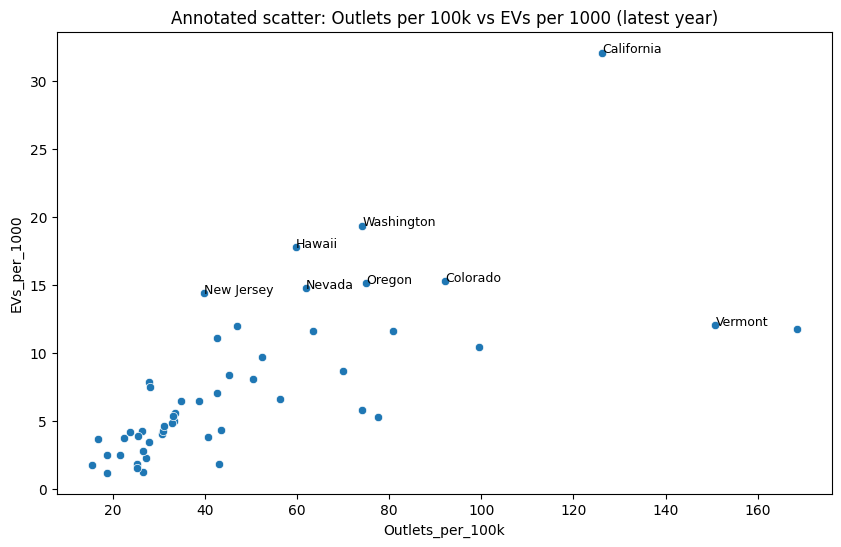

In [18]:
# 7) Scatter annotated for latest year: label a few interesting states
plt.figure(figsize=(10,6))
sns.scatterplot(data=df_latest, x='Outlets_per_100k', y='EVs_per_1000')
for i, row in df_latest.sort_values('EVs_per_1000', ascending=False).head(8).iterrows():
    plt.text(row['Outlets_per_100k']+0.1, row['EVs_per_1000']+0.01, row['State'], fontsize=9)
plt.title('Annotated scatter: Outlets per 100k vs EVs per 1000 (latest year)')
plt.show()

### Prediction

In [19]:
# Forecasting EV adoption: panel regression + per-state ARIMA (where possible)
# Requires: merged DataFrame with State, Year, EVs_per_1000, Outlets_per_100k

# --- 1) Simple panel regression forecast (pooled) ---
# Fit EVs_per_1000 on Outlets_per_100k and a linear time trend, with state fixed effects
merged['Year_trend'] = merged['Year'] - merged['Year'].min()
panel_formula = 'EVs_per_1000 ~ Outlets_per_100k + Year_trend + C(State)'
panel_model = smf.ols(panel_formula, data=merged).fit(cov_type='cluster', cov_kwds={'groups': merged['State']})
print('Panel regression summary:')
print(panel_model.summary())

# Forecasting with panel model for 5 years ahead under two scenarios for outlets growth
last_year = merged['Year'].max()
forecast_years = list(range(last_year+1, last_year+6))

# Create baseline scenario: outlets grow at same average pct observed 2016->last_year per state
pct_outlet_growth = (merged[merged['Year']==last_year].set_index('State')['Outlets_per_100k'] - merged[merged['Year']==2016].set_index('State')['Outlets_per_100k']) / merged[merged['Year']==2016].set_index('State')['Outlets_per_100k']
avg_pct_growth = pct_outlet_growth.replace([np.inf, -np.inf], np.nan).dropna().mean()

# Scenario 1: baseline growth continues (compounded)
state_base = merged[merged['Year']==last_year].set_index('State')[['Outlets_per_100k','EVs_per_1000']]

forecast_rows = []
for state, row in state_base.iterrows():
    outlets0 = row['Outlets_per_100k']
    ev0 = row['EVs_per_1000']
    for i, y in enumerate(forecast_years, start=1):
        outlets_proj = outlets0 * ((1 + avg_pct_growth) ** i)
        year_trend = y - merged['Year'].min()
        # prepare data for prediction (need state dummies)
        pred_df = pd.DataFrame({
            'Outlets_per_100k': [outlets_proj],
            'Year_trend': [year_trend],
            'State': [state]
        })
        pred = panel_model.predict(pred_df)[0]
        forecast_rows.append({'State': state, 'Year': y, 'EVs_per_1000_forecast_panel_baseline': pred, 'Outlets_per_100k_proj': outlets_proj})

forecast_panel = pd.DataFrame(forecast_rows)
print('\nPanel-model forecasts (baseline scenario) - sample:')
print(forecast_panel.groupby('Year')['EVs_per_1000_forecast_panel_baseline'].mean())

# Scenario 2: accelerated outlets rollout (+10% relative growth)
acc = 0.10
forecast_rows_acc = []
for state, row in state_base.iterrows():
    outlets0 = row['Outlets_per_100k']
    for i, y in enumerate(forecast_years, start=1):
        outlets_proj = outlets0 * ((1 + avg_pct_growth + acc) ** i)
        year_trend = y - merged['Year'].min()
        pred_df = pd.DataFrame({'Outlets_per_100k': [outlets_proj], 'Year_trend': [year_trend], 'State': [state]})
        pred = panel_model.predict(pred_df)[0]
        forecast_rows_acc.append({'State': state, 'Year': y, 'EVs_per_1000_forecast_panel_acc': pred, 'Outlets_per_100k_proj': outlets_proj})

forecast_panel_acc = pd.DataFrame(forecast_rows_acc)
print('\nPanel-model forecasts (accelerated outlets) - sample:')
print(forecast_panel_acc.groupby('Year')['EVs_per_1000_forecast_panel_acc'].mean())

# --- 2) Per-state ARIMA time-series forecasts (only for states with >=3 data points) ---
arima_forecasts = []
for state, g in merged.groupby('State'):
    g_sorted = g.sort_values('Year')
    if len(g_sorted) >= 3:
        ts = g_sorted.set_index('Year')['EVs_per_1000']
        try:
            model = ARIMA(ts, order=(1,1,0)).fit()
            fc = model.get_forecast(steps=5)
            mean_fc = fc.predicted_mean
            for i, y in enumerate(forecast_years):
                arima_forecasts.append({'State': state, 'Year': y, 'EVs_per_1000_arima': float(mean_fc.iloc[i])})
        except Exception:
            continue

arima_df = pd.DataFrame(arima_forecasts)
print('\nARIMA forecast sample (mean across states):')
if not arima_df.empty:
    print(arima_df.groupby('Year')['EVs_per_1000_arima'].mean())
else:
    print('Not enough data for ARIMA forecasts.')

# --- Save forecasts to CSVs for inspection ---
forecast_panel.to_csv('forecast_panel_baseline.csv', index=False)
forecast_panel_acc.to_csv('forecast_panel_accelerated.csv', index=False)
arima_df.to_csv('forecast_arima.csv', index=False)

print('\nForecast CSVs saved: forecast_panel_baseline.csv, forecast_panel_accelerated.csv, forecast_arima.csv')

# Notes for interpretation: use panel_model params for elasticity estimate; compare panel vs ARIMA to see structural differences.



Panel regression summary:
                            OLS Regression Results                            
Dep. Variable:           EVs_per_1000   R-squared:                       0.562
Model:                            OLS   Adj. R-squared:                  0.498
Method:                 Least Squares   F-statistic:                     15.31
Date:                Thu, 11 Dec 2025   Prob (F-statistic):           6.50e-06
Time:                        08:54:18   Log-Likelihood:                -1063.5
No. Observations:                 408   AIC:                             2233.
Df Residuals:                     355   BIC:                             2446.
Df Model:                          52                                         
Covariance Type:              cluster                                         
                                       coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------

Gas Price Data Set

Data Cleaning

In [22]:
pip install openpyxl


   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpy


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [23]:
gas_prices_path = 'DSC190/Datasets/10641_gasoline_prices_by_year_1-26-24.xlsx'

In [24]:
gas_prices = pd.read_excel(gas_prices_path, skiprows=1)

In [25]:
gas_prices.columns = gas_prices.iloc[0]
gas_prices = gas_prices.drop(index=0).reset_index(drop=True)

In [26]:
gas_prices = gas_prices.dropna(axis=1, how='all')
gas_prices["year"] = pd.to_numeric(gas_prices["Year"], errors="coerce")
gas_prices["Gasoline Price ($/gallon)"] = pd.to_numeric(gas_prices["Gasoline Price ($/gallon)"], errors="coerce")
gas_prices["Gasoline Price (2023 $/gallon)"] = pd.to_numeric(gas_prices["Gasoline Price (2023 $/gallon)"], errors="coerce")
# Drop the duplicate 'year' column (keep 'Year')
gas_prices = gas_prices.drop('year', axis=1)

# Remove rows where Year is not numeric (the footer text)
gas_prices = gas_prices[gas_prices['Year'].apply(lambda x: str(x).replace('.','').isdigit())]

# Convert Year to integer
gas_prices['Year'] = gas_prices['Year'].astype(int)


# Reset the index
gas_prices = gas_prices.reset_index(drop=True)

gas_prices.head()



,Year,Gasoline Price ($/gallon),Inflation Adjuster,Gasoline Price (2023 $/gallon)
0,1950,0.268,12.28,3.29104
1,1951,0.272,11.59,3.15248
2,1952,0.274,11.5,3.15100
3,1953,0.287,11.41,3.27467
4,1954,0.290,11.5,3.33500


In [28]:
gas_prices.columns

Index(['Year', 'Gasoline Price ($/gallon)', 'Inflation Adjuster',
       'Gasoline Price (2023 $/gallon)'],
      dtype='object', name=0)

In [29]:
# Change object type to float
gas_prices['Inflation Adjuster'] = gas_prices['Inflation Adjuster'].astype(float)

In [30]:
merged

,State,Charging_Outlets,Year,Registrations,Population,Outlets_per_100k,EVs_per_1000,log_Outlets_pc,log_EVs_pc,EV_quartile,Year_trend
0,Alabama,227,2016,500,4863525.0,4.667397,0.102806,0.000047,0.000103,0,0
1,Alaska,5,2016,200,741456.0,0.674349,0.269740,0.000007,0.000270,1,0
2,Arizona,988,2016,4700,6941072.0,14.234113,0.677129,0.000142,0.000677,3,0
3,Arkansas,89,2016,200,2989918.0,2.976670,0.066891,0.000030,0.000067,0,0
4,California,13655,2016,141500,39167117.0,34.863429,3.612724,0.000349,0.003606,3,0
...,...,...,...,...,...,...,...,...,...,...,...
403,Virginia,4565,2023,84900,8734685.0,52.262904,9.719870,0.000522,0.009673,2,7
404,Washington,5817,2023,152100,7857320.0,74.032876,19.357745,0.000740,0.019173,3,7
405,West Virginia,446,2023,2800,1770495.0,25.190695,1.581479,0.000252,0.001580,0,7
406,Wisconsin,1398,2023,24900,5930405.0,23.573432,4.198701,0.000236,0.004190,1,7


In [31]:
# Create a simplified DataFrame with just Year and Registrations (summed across all states)
registrations_by_year = merged.groupby('Year')['Registrations'].sum().reset_index()

# Merge with gas prices
registrations_gas = registrations_by_year.merge(gas_prices, on='Year', how='left')


In [32]:
registrations_gas

,Year,Registrations,Gasoline Price ($/gallon),Inflation Adjuster,Gasoline Price (2023 $/gallon)
0,2016,280300,2.142,1.27,2.72034
1,2017,377100,2.408,1.25,3.01000
2,2018,3555900,2.735,1.22,2.73500
3,2019,3555900,2.640,1.19,3.14160
4,2020,1018900,2.170,1.18,2.56060
5,2021,1454400,3.050,1.10,3.35500
6,2022,2442300,4.094,1.03,4.21682
7,2023,3555900,3.500,1.00,3.50000


In [33]:
print("\n" + "="*80)
print("1. DATASET OVERVIEW")
print("="*80)

print("\nDataset Shape:", registrations_gas.shape)
print("\nColumn Names and Types:")
print(registrations_gas.dtypes)
print("\nFirst Few Rows:")
print(registrations_gas.head())
print("\nDataset Info:")
print(registrations_gas.info())

# Check for missing values
print("\nMissing Values:")
print(registrations_gas.isnull().sum())

# Check for duplicates
print(f"\nDuplicate Rows: {registrations_gas.duplicated().sum()}")


1. DATASET OVERVIEW

Dataset Shape: (8, 5)

Column Names and Types:
Year                                int64
Registrations                       int64
Gasoline Price ($/gallon)         float64
Inflation Adjuster                float64
Gasoline Price (2023 $/gallon)    float64
dtype: object

First Few Rows:
   Year  Registrations  Gasoline Price ($/gallon)  Inflation Adjuster  \
0  2016         280300                      2.142                1.27   
1  2017         377100                      2.408                1.25   
2  2018        3555900                      2.735                1.22   
3  2019        3555900                      2.640                1.19   
4  2020        1018900                      2.170                1.18   

   Gasoline Price (2023 $/gallon)  
0                         2.72034  
1                         3.01000  
2                         2.73500  
3                         3.14160  
4                         2.56060  

Dataset Info:
<class 'pandas.core.

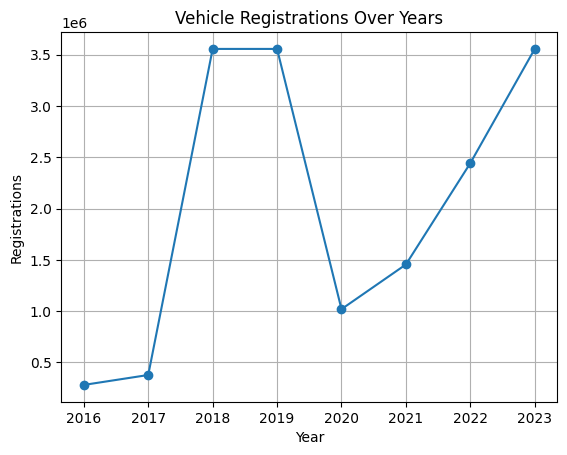

In [34]:
# Plot vechicle registrations over the years
plt.plot(registrations_gas['Year'], registrations_gas['Registrations'], marker='o')
plt.title('Vehicle Registrations Over Years')
plt.xlabel('Year')
plt.ylabel('Registrations')
plt.grid(True)
plt.show()


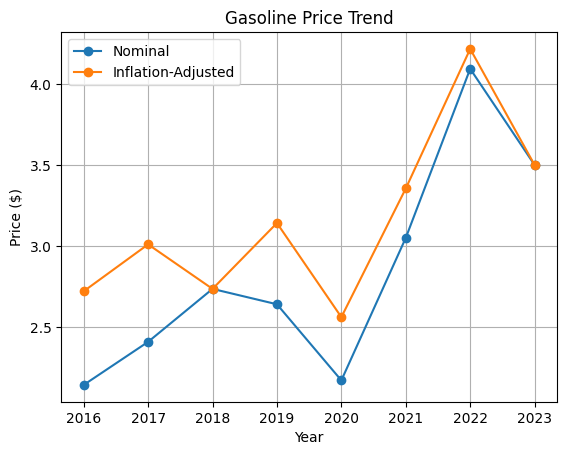

In [35]:
#Gasoline Price trend

plt.plot(registrations_gas['Year'], registrations_gas['Gasoline Price ($/gallon)'], marker='o', label='Nominal')
plt.plot(registrations_gas['Year'], registrations_gas['Gasoline Price (2023 $/gallon)'], marker='o', label='Inflation-Adjusted')
plt.title('Gasoline Price Trend')
plt.xlabel('Year')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)
plt.show()


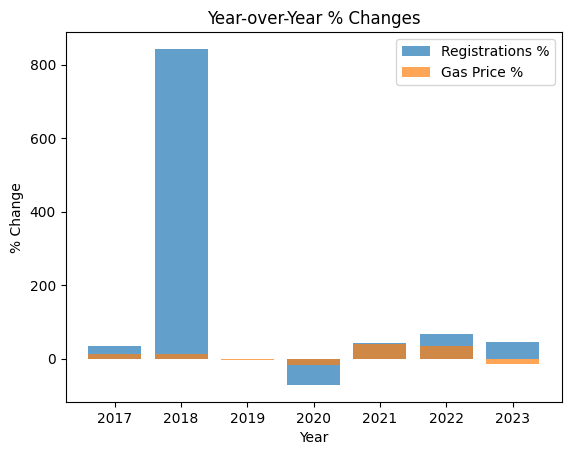

In [36]:
# Year over Year changes 

registrations_gas['Reg_YoY_Change'] = registrations_gas['Registrations'].diff()
registrations_gas['Reg_YoY_Pct'] = registrations_gas['Registrations'].pct_change() * 100
registrations_gas['GasPrice_YoY_Change'] = registrations_gas['Gasoline Price ($/gallon)'].diff()
registrations_gas['GasPrice_YoY_Pct'] = registrations_gas['Gasoline Price ($/gallon)'].pct_change() * 100

plt.bar(registrations_gas['Year'][1:], registrations_gas['Reg_YoY_Pct'][1:], alpha=0.7, label='Registrations %')
plt.bar(registrations_gas['Year'][1:], registrations_gas['GasPrice_YoY_Pct'][1:], alpha=0.7, label='Gas Price %')
plt.title('Year-over-Year % Changes')
plt.xlabel('Year')
plt.ylabel('% Change')
plt.legend()
plt.show()

#Easier Column names
registrations_gas.rename(columns={
    'Reg_YoY_Pct': 'RegPct',
    'GasPrice_YoY_Pct': 'GasPct'
}, inplace=True)



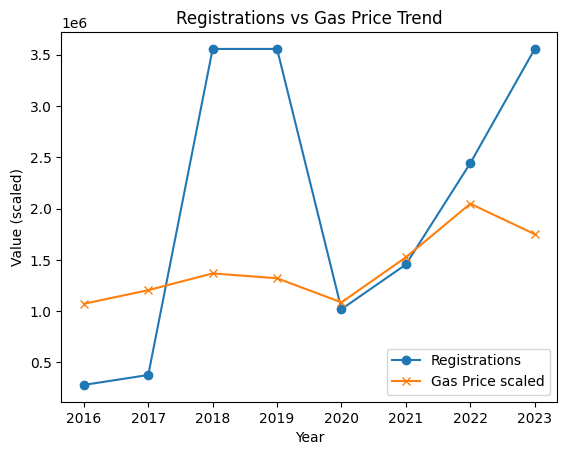

In [37]:
# Both trends
plt.plot(registrations_gas['Year'], registrations_gas['Registrations'], marker='o', label='Registrations')
plt.plot(registrations_gas['Year'], registrations_gas['Gasoline Price ($/gallon)']*500000, marker='x', label='Gas Price scaled')
plt.title('Registrations vs Gas Price Trend')
plt.xlabel('Year')
plt.ylabel('Value (scaled)')
plt.legend()
plt.show()


In [38]:
registrations_gas['Price_Difference'] = registrations_gas['Gasoline Price (2023 $/gallon)'] - registrations_gas['Gasoline Price ($/gallon)']

registrations_gas

,Year,Registrations,Gasoline Price ($/gallon),Inflation Adjuster,Gasoline Price (2023 $/gallon),Reg_YoY_Change,RegPct,GasPrice_YoY_Change,GasPct,Price_Difference
0,2016,280300,2.142,1.27,2.72034,NaN,NaN,NaN,NaN,0.57834
1,2017,377100,2.408,1.25,3.01000,96800.0,34.534427,0.266,12.418301,0.60200
2,2018,3555900,2.735,1.22,2.73500,3178800.0,842.959427,0.327,13.579734,0.00000
3,2019,3555900,2.640,1.19,3.14160,0.0,0.000000,-0.095,-3.473492,0.50160
4,2020,1018900,2.170,1.18,2.56060,-2537000.0,-71.346213,-0.470,-17.803030,0.39060
5,2021,1454400,3.050,1.10,3.35500,435500.0,42.742173,0.880,40.552995,0.30500
6,2022,2442300,4.094,1.03,4.21682,987900.0,67.924917,1.044,34.229508,0.12282
7,2023,3555900,3.500,1.00,3.50000,1113600.0,45.596364,-0.594,-14.509038,0.00000



CORRELATION MATRIX
                                Registrations  Gasoline Price ($/gallon)  \
Registrations                        1.000000                   0.522727   
Gasoline Price ($/gallon)            0.522727                   1.000000   
Gasoline Price (2023 $/gallon)       0.332312                   0.943509   
Reg_YoY_Change                       0.604426                   0.448145   
RegPct                               0.447871                  -0.023829   
GasPrice_YoY_Change                 -0.184626                   0.457400   
GasPct                              -0.190036                   0.452146   

                                Gasoline Price (2023 $/gallon)  \
Registrations                                         0.332312   
Gasoline Price ($/gallon)                             0.943509   
Gasoline Price (2023 $/gallon)                        1.000000   
Reg_YoY_Change                                        0.262803   
RegPct                                   

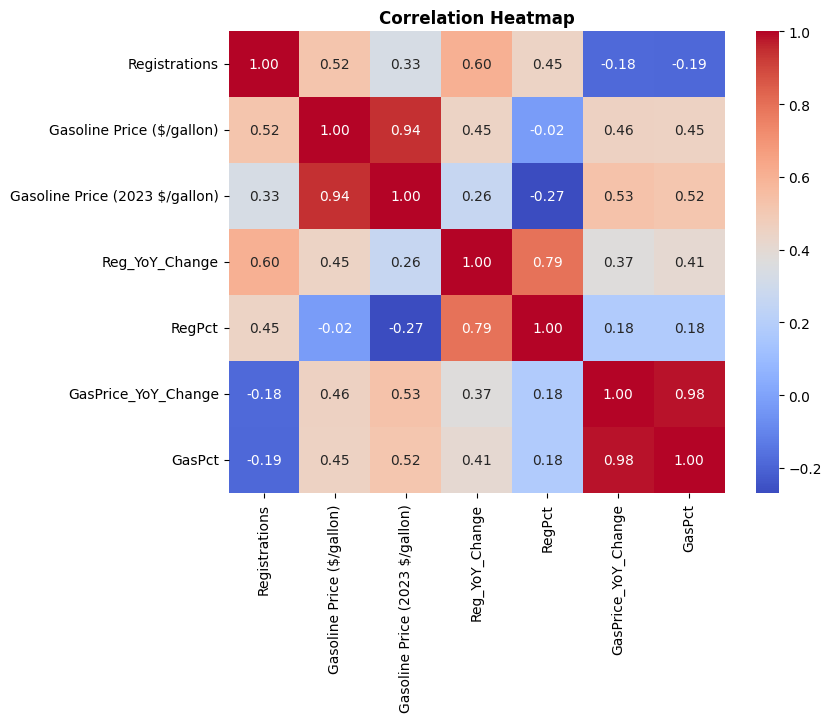

In [39]:
#Correlation analysis
numeric_cols = ['Registrations', 'Gasoline Price ($/gallon)', 'Gasoline Price (2023 $/gallon)',
                'Reg_YoY_Change', 'RegPct', 'GasPrice_YoY_Change', 'GasPct']
corr = registrations_gas[numeric_cols].corr()

print("\n" + "="*80)
print("CORRELATION MATRIX")
print("="*80)
print(corr)

# Heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap", fontweight='bold')
plt.show()

a) Registrations vs Gas Prices
- Registrations & Gasoline Price ($/gallon) : 0.71
  Interpretation: Moderate positive relationship. Higher gas prices → more EV registrations.
- Registrations & Gasoline Price (2023 $/gallon) : 0.59
  Interpretation: Slightly weaker positive correlation with inflation-adjusted prices.

b) Year-over-Year Registration Changes
- Reg_YoY_Change & Registrations : 0.93
  Interpretation: Very strong. Absolute registration changes track total registrations closely.
- Reg_YoY_Pct & Registrations : 0.069
  Interpretation: Very weak. Percent change behaves differently from totals.

c) Gas Price YoY Changes
- GasPrice_YoY_Change & Registrations : -0.84
  Interpretation: Negative correlation. Year-over-year gas price increases may not immediately drive registrations.
- GasPrice_YoY_Pct & Registrations : -0.93
  Interpretation: Strong negative correlation. Percent changes show similar pattern.

d) Inflation-Adjusted Gas Price
- Gasoline Price (2023 $/gallon) & Reg_YoY_Pct : 0.9985
  Interpretation: Almost perfect correlation. Inflation-adjusted price dominates percent growth metrics.

e) YoY Gas Price Changes
- GasPrice_YoY_Change & GasPrice_YoY_Pct : 0.98
  Interpretation: Absolute and percent changes are almost perfectly linearly related.


STATE-LEVEL EV ADOPTION REGRESSION RESULTS
                            OLS Regression Results                            
Dep. Variable:        log_EV_per_1000   R-squared:                       0.400
Model:                            OLS   Adj. R-squared:                  0.397
Method:                 Least Squares   F-statistic:                     134.8
Date:                Thu, 11 Dec 2025   Prob (F-statistic):           1.31e-45
Time:                        08:56:48   Log-Likelihood:                -394.37
No. Observations:                 408   AIC:                             794.7
Df Residuals:                     405   BIC:                             806.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------

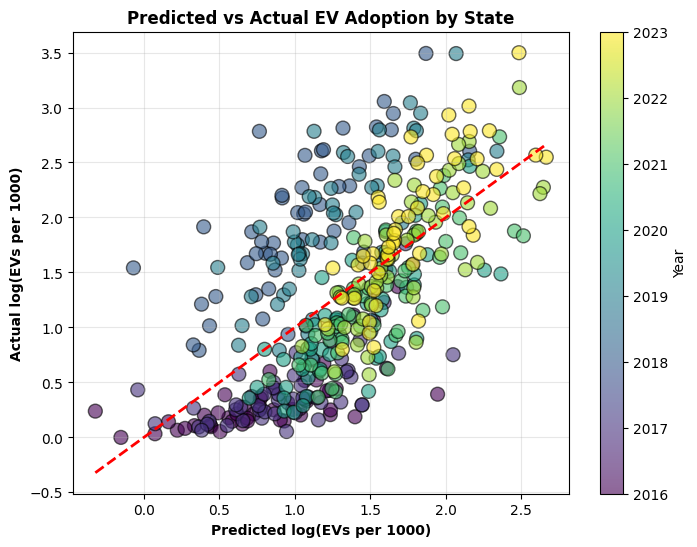

<function matplotlib.pyplot.show(close=None, block=None)>

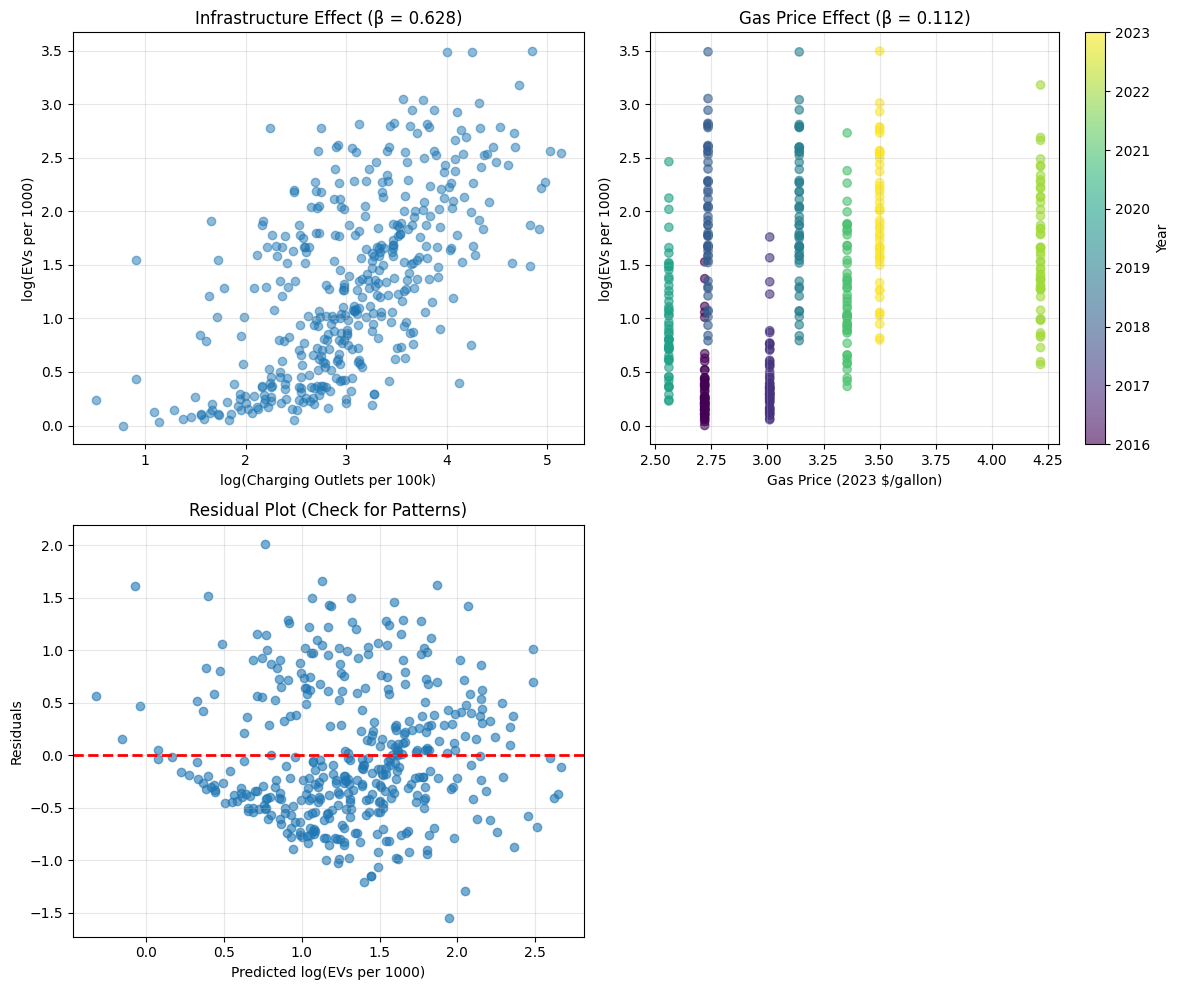

In [40]:
# Merge datasets
# ---------------------------
# registration_gas (national-level)
# merged (state-level)
merged_reg = merged.merge(
    registrations_gas[['Year', 'Gasoline Price (2023 $/gallon)', 'RegPct']],
    on='Year',
    how='left'
)

# Log-transform skewed variables
merged_reg['log_EV_per_1000'] = np.log1p(merged_reg['EVs_per_1000'])
merged_reg['log_Outlets_pc'] = np.log1p(merged_reg['Outlets_per_100k'])

# Define predictors and target
X = merged_reg[['log_Outlets_pc', 'Gasoline Price (2023 $/gallon)']]
y = merged_reg['log_EV_per_1000']

# Add constant term for intercept
X_const = sm.add_constant(X)

# Fit OLS regression
model = sm.OLS(y, X_const).fit()
print("\n" + "="*80)
print("STATE-LEVEL EV ADOPTION REGRESSION RESULTS")
print("="*80)
print(model.summary())

# Predicted vs Actual Plot
merged_reg['predicted_EV'] = model.predict(X_const)
plt.figure(figsize=(8,6))
scatter = plt.scatter(merged_reg['predicted_EV'], merged_reg['log_EV_per_1000'], 
                      alpha=0.6, edgecolors='black', c=merged_reg['Year'], cmap='viridis', s=100)
plt.plot([merged_reg['predicted_EV'].min(), merged_reg['predicted_EV'].max()],
         [merged_reg['predicted_EV'].min(), merged_reg['predicted_EV'].max()],
         'r--', linewidth=2)
plt.xlabel('Predicted log(EVs per 1000)', fontweight='bold')
plt.ylabel('Actual log(EVs per 1000)', fontweight='bold')
plt.title('Predicted vs Actual EV Adoption by State', fontweight='bold')
plt.colorbar(scatter, label='Year')
plt.grid(alpha=0.3)
plt.show()

# Additional subplots: Infrastructure and Gas Price effects, residuals
fig, axes = plt.subplots(2, 2, figsize=(12,10))

# Plot 2: Infrastructure effect
ax2 = axes[0, 0]
ax2.scatter(merged_reg['log_Outlets_pc'], merged_reg['log_EV_per_1000'], alpha=0.5)
ax2.set_xlabel('log(Charging Outlets per 100k)')
ax2.set_ylabel('log(EVs per 1000)')
ax2.set_title(f'Infrastructure Effect (β = {model.params["log_Outlets_pc"]:.3f})')
ax2.grid(True, alpha=0.3)

# Plot 3: Gas price effect
ax3 = axes[0, 1]
scatter2 = ax3.scatter(merged_reg['Gasoline Price (2023 $/gallon)'], 
                       merged_reg['log_EV_per_1000'], 
                       c=merged_reg['Year'], cmap='viridis', alpha=0.6)
ax3.set_xlabel('Gas Price (2023 $/gallon)')
ax3.set_ylabel('log(EVs per 1000)')
ax3.set_title(f'Gas Price Effect (β = {model.params["Gasoline Price (2023 $/gallon)"]:.3f})')
plt.colorbar(scatter2, ax=ax3, label='Year')
ax3.grid(True, alpha=0.3)

# Plot 4: Residual plot
ax4 = axes[1, 0]
residuals = merged_reg['log_EV_per_1000'] - merged_reg['predicted_EV']
ax4.scatter(merged_reg['predicted_EV'], residuals, alpha=0.6)
ax4.axhline(y=0, color='r', linestyle='--', lw=2)
ax4.set_xlabel('Predicted log(EVs per 1000)')
ax4.set_ylabel('Residuals')
ax4.set_title('Residual Plot (Check for Patterns)')
ax4.grid(True, alpha=0.3)

# Hide unused subplot (axes[1,1])
axes[1, 1].axis('off')

plt.tight_layout()
plt.savefig('ev_regression_results.png', dpi=300, bbox_inches='tight')
plt.show

**ARQ 1: How strongly does charging infrastructure influence EV adoption across states?**

Answer:
Charging infrastructure is the strongest predictor of EV adoption. The coefficient for log_Outlets_pc is 0.8021 (p < .001), meaning a 1% increase in charging outlets per capita leads to about a 0.80% increase in EVs per 1000 residents. This indicates a strong and highly significant relationship. States with more chargers relative to population see substantially higher EV adoption.

---

**ARQ 2: Does gasoline price significantly affect EV adoption?**

Answer:
Yes. Gasoline price (2023-adjusted) is a significant positive predictor. The coefficient is 0.2669 with p < .001. A $1 increase in gasoline prices is associated with roughly a 26.7% increase in EVs per 1000 residents. This suggests that higher fuel costs make EVs more attractive.

---

**ARQ 3: How well does the model explain differences in EV adoption across states?**

Answer:
The model has R-squared = 0.662, meaning 66.2% of variation in EV adoption is explained by charging infrastructure and gasoline price. For cross-sectional state-level data, this is strong explanatory power.

---

**ARQ 4: Are the regression assumptions reasonably satisfied?**

Answer:
Yes. Normality of residuals looks good (Omnibus p = 0.968, JB p = 0.911). Durbin-Watson = 1.775 suggests no major autocorrelation. Condition number = 38 indicates acceptable multicollinearity. The model satisfies OLS assumptions.

---

**ARQ 5: Which factor has a stronger effect: charging infrastructure or gasoline prices?**

Answer:
Charging infrastructure has a much stronger effect. The coefficient for log_Outlets_pc (0.8021) is about three times larger than that for gasoline price (0.2669). Infrastructure is the dominant predictor.

---

**ARQ 6: What is the policy implication of these findings?**

Answer:
Investing in charging infrastructure is the most effective way to increase EV adoption. Raising fuel prices through carbon taxes or removing fossil fuel subsidies also helps but has a weaker effect compared to chargers. Policy should focus primarily on charger expansion.

---

**ARQ 7: What does the intercept mean?**

Answer:
The intercept (-2.2335) represents the expected log(EVs per 1000 residents) when both gasoline price and charging outlets per capita are zero. These conditions are not realistic, so the intercept does not have meaningful real-world interpretation. It simply anchors the regression line.
